# Package

In [ ]:
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available()

print('Torch Version : {}'.format(torch.__version__))
print('CUDA Available : {}'.format(is_cuda))
if is_cuda :
  cuda_count = torch.cuda.device_count()
  print('CUDA Count : {}'.format(cuda_count))
  for i in range(cuda_count) :
    print('CUDA Device : {}'.format(torch.cuda.get_device_name(i)))

Torch Version : 1.9.0+cu102
CUDA Available : True
CUDA Count : 1
CUDA Device : Tesla T4


# 데이터 로드
  - CIFAR 10

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 데이터 확인

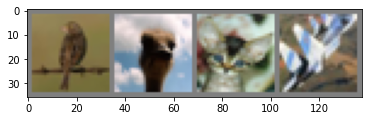

 bird  bird   cat plane


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# 모델

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 모델 생성
  - is_cuda 에 따라 'cuda'와 'cpu' 선택
  - 학습율 : 0.001
  - 목적함수 : 교차 엔트로피
  - 최적화 : Adam

In [ ]:
device = 'cuda' if is_cuda else 'cpu'
learning_rate = 0.001

net = Net().to(device)
critetion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# 학습

In [ ]:
n_epochs = 2

start_time = time.time()

for epoch in range(n_epochs) :
  print('Epochs {}/{} ================'.format(epoch+1, n_epochs))
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0) :
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = critetion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999 :
      print(' {:5d}/{:5d} loss: {:.3f}'.format(i+1, len(trainloader), running_loss / 2000))
      running_loss = 0.0

print('\nFinished Training \n Train time : {:.2f}s'.format(time.time() - start_time))

Epochs 1/2 ================
  2000/12500 loss: 1.886
  4000/12500 loss: 1.592
  6000/12500 loss: 1.503
  8000/12500 loss: 1.486
 10000/12500 loss: 1.418
 12000/12500 loss: 1.378
Epochs 2/2 ================
  2000/12500 loss: 1.330
  4000/12500 loss: 1.306
  6000/12500 loss: 1.278
  8000/12500 loss: 1.276
 10000/12500 loss: 1.271
 12000/12500 loss: 1.257

Finished Training 
 Train time : 105.86s


## 가중치 저장

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 학습된 모델 테스트

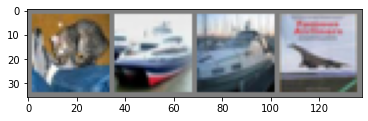

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 가중치 불러오기

In [ ]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 예측

In [ ]:
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car  ship plane


## 성능 평가

### 전체 평가

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


### 클래스별 평가

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

Accuracy for class plane is: 55.0 %
Accuracy for class car   is: 75.8 %
Accuracy for class bird  is: 28.3 %
Accuracy for class cat   is: 47.7 %
Accuracy for class deer  is: 48.0 %
Accuracy for class dog   is: 47.6 %
Accuracy for class frog  is: 62.2 %
Accuracy for class horse is: 68.4 %
Accuracy for class ship  is: 65.6 %
Accuracy for class truck is: 57.3 %
